# Logistic Regression Classifiers Amazon Review Summaries

In this notebook we will apply `LogisticRegression` to a binary classficiation problem
problem.

As the bag of words representation of a document is high dimensional we will use $\chi^2$ feature selection to select a subspace of a manageable dimension. 


## Preliminaries

### Imports

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# for a progress bar on slow calculations
from ipywidgets import IntProgress
from IPython.display import display

import sys
sys.path.append("../..")
from E4525_ML import plots
import E4525_ML.text as text
from E4525_ML.multiclass_logistic import LogisticGDClassifier
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots

In [2]:
seed=23
np.random.seed(seed)

### Data

#### Data Directories

In [3]:
data_dir=r"../../raw/amazon-reviews"

#### Corpus

In [4]:
documents_filename=data_dir+"/documents.csv"
documents=pd.read_csv(documents_filename)
documents["Summary"].fillna("",inplace=True)
documents.head()

,Summary,Score
0,Nice,5
1,No taste or flavor,2
2,spicy thai chips,5
3,I'm Loven The Mount Hagen!,5
4,Bigelow Tea Chest,2


In [5]:
test_documents_filename=data_dir+"/documents_test.csv"
test_documents=pd.read_csv(test_documents_filename)
test_documents["Summary"].fillna("",inplace=True)
test_documents.head()

,Summary,Score
0,Huge disappointment,1
1,In lieu of the now bastardized American black ...,3
2,Wow.,5
3,Tastes just like the store,5
4,a very handi snack,5



## Validation Set Creation

In [6]:
docs_train,docs_val,label_train,label_val=train_test_split(documents["Summary"],documents["Score"],test_size=0.2)

In [7]:
Y_train=label_train>3
Y_val=label_val>3

## Generic Text Classifier with Feature Selection

Selection $F$ features base of a $\chi^2$ test makes sense for any classifier.

For convenience we create a new wrapper classifier that selects $F$ features and calls the underlying
classier with them.

In [8]:
class TextChi2Classifier:
    def __init__(self,F,model):
        self.model=model
        self.transformer=SelectKBest(chi2,F)
    def fit(self,X,Y,X_val=None,Y_val=None):
        dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
        Z=dummies
        Xt=self.transformer.fit_transform(X,Z)
        Xt_val=None
        if (not (X_val is None)):
            Xt_val=self.transformer.transform(X_val)
        self.model.fit(Xt,Y,Xt_val,Y_val)
        return self
    def predict(self,X):
        Xt=self.transformer.transform(X)
        return self.model.predict(Xt)
    def predict_proba(self,X):
        Xt=self.transformer.transform(X)
        return self.model.predict_proba(Xt)

In [9]:
countVectorizer=CountVectorizer(input="content")

In [10]:
X=countVectorizer.fit_transform(docs_train)
X_val=countVectorizer.transform(docs_val)
Y=Y_train

In [11]:
V=X.shape[1]
V

29084

In [12]:
base_model=LogisticGDClassifier(max_iter=100, learning_rate=0.005,tol=1e-8)

In [13]:
F=1000

In [14]:
modelT=TextChi2Classifier(F,base_model)

In [15]:
modelT.fit(X,Y,X_val,Y_val)

	 0 Loss = 694.3814033060282 Train_Accuracy 0.486 Evaluation Loss = 695.5799487147383 Accuracy = 0.468
	 10 Loss = 291.3810585812772 Train_Accuracy 0.886 Evaluation Loss = 314.86817904286573 Accuracy = 0.866
	 20 Loss = 266.37244396181256 Train_Accuracy 0.904 Evaluation Loss = 321.65899448925563 Accuracy = 0.861
	 30 Loss = 292.5577553480849 Train_Accuracy 0.886 Evaluation Loss = 307.31609740925273 Accuracy = 0.883
	 40 Loss = 296.2300938608464 Train_Accuracy 0.881 Evaluation Loss = 315.6748974738257 Accuracy = 0.865
	 50 Loss = 292.3599124065488 Train_Accuracy 0.883 Evaluation Loss = 292.4774083290627 Accuracy = 0.883
	 60 Loss = 307.25681602989175 Train_Accuracy 0.869 Evaluation Loss = 299.4299727273892 Accuracy = 0.877
	 70 Loss = 287.4125703584782 Train_Accuracy 0.883 Evaluation Loss = 306.7181224645605 Accuracy = 0.873
	 80 Loss = 309.179228609953 Train_Accuracy 0.869 Evaluation Loss = 304.4187182424062 Accuracy = 0.879
	 90 Loss = 273.85731570380875 Train_Accuracy 0.881 Evaluatio

In [16]:
Y_pred=modelT.predict(X_val)
np.mean(Y_pred==Y_val)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8784914290181974

In [17]:
prob=modelT.predict_proba(X_val)
fpr,tpr,threshold=metrics.roc_curve(Y_val,prob[:,1])

In [18]:
auc=metrics.roc_auc_score(Y_val,prob[:,1])
print(auc)

0.9130896668762072


 ##  LogisticRegression Classifier vs Number of Features

In [19]:
Fs=[100,200,500,1000,5000,10000,20000,V]

In [20]:
# Display a progress bar that counts how many training rounds we have done so far
progress2= IntProgress(min=0, max=len(Fs),description="Trials:",bar_style="info")
display(progress2)


logistic_train_error=[]
logistic_val_error=[]
progress2.value=0
for F in Fs:
    model=TextChi2Classifier(F,base_model)
    model.fit(X,Y,X_val,Y_val)
    Y_pred=model.predict(X)
    logistic_train_error.append(1-np.mean(Y_pred==Y))
    Y_pred=model.predict(X_val)
    logistic_val_error.append(1-np.mean(Y_pred==Y_val))
    progress2.value+=1
print("Done.")

IntProgress(value=0, bar_style='info', description='Trials:', max=8)

	 0 Loss = 713.6237070970609 Train_Accuracy 0.357 Evaluation Loss = 712.4869763573076 Accuracy = 0.361
	 10 Loss = 344.4045245679549 Train_Accuracy 0.871 Evaluation Loss = 353.64928632275956 Accuracy = 0.846
	 20 Loss = 333.89658685308916 Train_Accuracy 0.864 Evaluation Loss = 371.2266097373361 Accuracy = 0.834
	 30 Loss = 337.9133813651735 Train_Accuracy 0.871 Evaluation Loss = 330.6760442926062 Accuracy = 0.863
	 40 Loss = 362.08642361375325 Train_Accuracy 0.849 Evaluation Loss = 351.2564216814226 Accuracy = 0.851
	 50 Loss = 386.0017324951782 Train_Accuracy 0.833 Evaluation Loss = 369.03078084960856 Accuracy = 0.839
	 60 Loss = 374.2262646253451 Train_Accuracy 0.846 Evaluation Loss = 379.6055671945113 Accuracy = 0.832
	 70 Loss = 336.6039406336417 Train_Accuracy 0.862 Evaluation Loss = 353.4635563968813 Accuracy = 0.856
	 80 Loss = 350.70467782206435 Train_Accuracy 0.862 Evaluation Loss = 354.68256468618677 Accuracy = 0.863
	 90 Loss = 335.92774220954504 Train_Accuracy 0.875 Evaluat

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 691.2385923217765 Train_Accuracy 0.418 Evaluation Loss = 696.553982405238 Accuracy = 0.39
	 10 Loss = 305.8965203121561 Train_Accuracy 0.879 Evaluation Loss = 349.647258603299 Accuracy = 0.857
	 20 Loss = 326.5539355678069 Train_Accuracy 0.872 Evaluation Loss = 357.1840692163496 Accuracy = 0.853
	 30 Loss = 322.10360873912373 Train_Accuracy 0.855 Evaluation Loss = 344.41507532458405 Accuracy = 0.855
	 40 Loss = 318.0759393759334 Train_Accuracy 0.879 Evaluation Loss = 319.21534069155643 Accuracy = 0.874
	 50 Loss = 361.27509246425785 Train_Accuracy 0.848 Evaluation Loss = 319.4162861340264 Accuracy = 0.87
	 60 Loss = 326.4764057749228 Train_Accuracy 0.873 Evaluation Loss = 309.1676113279509 Accuracy = 0.878
	 70 Loss = 330.72069313072063 Train_Accuracy 0.862 Evaluation Loss = 332.2607553811113 Accuracy = 0.869
	 80 Loss = 339.4627399009772 Train_Accuracy 0.857 Evaluation Loss = 343.04658203975555 Accuracy = 0.86
	 90 Loss = 339.7797318763867 Train_Accuracy 0.868 Evaluation Lo

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 686.602853024651 Train_Accuracy 0.512 Evaluation Loss = 684.7820998032828 Accuracy = 0.507
	 10 Loss = 313.4445709219756 Train_Accuracy 0.884 Evaluation Loss = 321.6066483481897 Accuracy = 0.877
	 20 Loss = 296.313252158016 Train_Accuracy 0.882 Evaluation Loss = 307.3796468577581 Accuracy = 0.866
	 30 Loss = 313.7452474670217 Train_Accuracy 0.867 Evaluation Loss = 299.9051011148208 Accuracy = 0.872
	 40 Loss = 336.86393604877765 Train_Accuracy 0.865 Evaluation Loss = 295.467789308193 Accuracy = 0.874
	 50 Loss = 317.59340830524945 Train_Accuracy 0.863 Evaluation Loss = 322.4139154316603 Accuracy = 0.867
	 60 Loss = 342.44539758318524 Train_Accuracy 0.857 Evaluation Loss = 321.4785971917603 Accuracy = 0.865
	 70 Loss = 330.81324131863664 Train_Accuracy 0.871 Evaluation Loss = 317.9725800657354 Accuracy = 0.868
	 80 Loss = 325.27108626646077 Train_Accuracy 0.861 Evaluation Loss = 321.57249801865987 Accuracy = 0.868
	 90 Loss = 308.2651825218126 Train_Accuracy 0.877 Evaluation 

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 692.7044082687056 Train_Accuracy 0.484 Evaluation Loss = 693.4865392546136 Accuracy = 0.487
	 10 Loss = 290.70792896137976 Train_Accuracy 0.88 Evaluation Loss = 281.8871636385619 Accuracy = 0.881
	 20 Loss = 297.1931383588426 Train_Accuracy 0.883 Evaluation Loss = 299.1978342041592 Accuracy = 0.885
	 30 Loss = 290.2819166778752 Train_Accuracy 0.884 Evaluation Loss = 280.39594059519885 Accuracy = 0.887
	 40 Loss = 263.61345645863264 Train_Accuracy 0.89 Evaluation Loss = 277.87333416706065 Accuracy = 0.887
	 50 Loss = 318.648093220675 Train_Accuracy 0.874 Evaluation Loss = 335.86400092421167 Accuracy = 0.868
	 60 Loss = 276.80480987110735 Train_Accuracy 0.895 Evaluation Loss = 270.69924963527103 Accuracy = 0.902
	 70 Loss = 299.02748071976964 Train_Accuracy 0.871 Evaluation Loss = 293.2039161363314 Accuracy = 0.88
	 80 Loss = 327.03296041541864 Train_Accuracy 0.873 Evaluation Loss = 305.26320522596154 Accuracy = 0.881
	 90 Loss = 323.5211983247735 Train_Accuracy 0.882 Evaluati

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 693.9175767068338 Train_Accuracy 0.498 Evaluation Loss = 693.3043915174072 Accuracy = 0.505
	 10 Loss = 286.5642818060368 Train_Accuracy 0.883 Evaluation Loss = 272.17194972669313 Accuracy = 0.891
	 20 Loss = 280.44612599148286 Train_Accuracy 0.891 Evaluation Loss = 294.5628001108789 Accuracy = 0.87
	 30 Loss = 281.61501297611517 Train_Accuracy 0.886 Evaluation Loss = 300.0706589142542 Accuracy = 0.882
	 40 Loss = 272.3238254055369 Train_Accuracy 0.896 Evaluation Loss = 288.9622531921241 Accuracy = 0.88
	 50 Loss = 255.5111838793165 Train_Accuracy 0.898 Evaluation Loss = 273.5031287621497 Accuracy = 0.893
	 60 Loss = 256.9793242701623 Train_Accuracy 0.893 Evaluation Loss = 270.0080238445288 Accuracy = 0.89
	 70 Loss = 248.59907646655034 Train_Accuracy 0.897 Evaluation Loss = 261.65269662602145 Accuracy = 0.896
	 80 Loss = 241.52046786090335 Train_Accuracy 0.907 Evaluation Loss = 256.6957246873074 Accuracy = 0.902
	 90 Loss = 285.1264819616451 Train_Accuracy 0.876 Evaluation 

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 693.5618499613255 Train_Accuracy 0.498 Evaluation Loss = 693.7852843442829 Accuracy = 0.494
	 10 Loss = 266.83189773673354 Train_Accuracy 0.895 Evaluation Loss = 296.2117689618572 Accuracy = 0.882
	 20 Loss = 259.4518292794857 Train_Accuracy 0.9 Evaluation Loss = 287.36530343717084 Accuracy = 0.894
	 30 Loss = 253.4906589408936 Train_Accuracy 0.904 Evaluation Loss = 290.6375584422618 Accuracy = 0.887
	 40 Loss = 272.98868144598794 Train_Accuracy 0.869 Evaluation Loss = 310.9376310839741 Accuracy = 0.875
	 50 Loss = 288.3844795316676 Train_Accuracy 0.882 Evaluation Loss = 259.3146357002005 Accuracy = 0.895
	 60 Loss = 262.1849218756039 Train_Accuracy 0.884 Evaluation Loss = 243.07448022901525 Accuracy = 0.905
	 70 Loss = 264.83094512983104 Train_Accuracy 0.89 Evaluation Loss = 284.88181138662617 Accuracy = 0.893
	 80 Loss = 257.10488873839574 Train_Accuracy 0.897 Evaluation Loss = 254.56228130218767 Accuracy = 0.899
	 90 Loss = 270.7894084303123 Train_Accuracy 0.883 Evaluatio

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 694.7189145417128 Train_Accuracy 0.443 Evaluation Loss = 694.1150499648229 Accuracy = 0.467
	 10 Loss = 277.2807905739496 Train_Accuracy 0.892 Evaluation Loss = 270.1910965569029 Accuracy = 0.894
	 20 Loss = 259.78357824018923 Train_Accuracy 0.898 Evaluation Loss = 318.5077763612704 Accuracy = 0.868
	 30 Loss = 263.1412989152965 Train_Accuracy 0.891 Evaluation Loss = 258.4379987578846 Accuracy = 0.898
	 40 Loss = 279.4672561375314 Train_Accuracy 0.898 Evaluation Loss = 252.6134232593878 Accuracy = 0.898
	 50 Loss = 257.323057443458 Train_Accuracy 0.896 Evaluation Loss = 281.8097778800626 Accuracy = 0.889
	 60 Loss = 262.7860372722128 Train_Accuracy 0.893 Evaluation Loss = 282.23554001323384 Accuracy = 0.878
	 70 Loss = 257.89426364960764 Train_Accuracy 0.898 Evaluation Loss = 272.34359706025805 Accuracy = 0.892
	 80 Loss = 206.4567588728832 Train_Accuracy 0.923 Evaluation Loss = 266.0666401562104 Accuracy = 0.893
	 90 Loss = 268.02473975603675 Train_Accuracy 0.896 Evaluation

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 693.5605275306441 Train_Accuracy 0.48 Evaluation Loss = 693.0227997603035 Accuracy = 0.495
	 10 Loss = 278.1077467128055 Train_Accuracy 0.879 Evaluation Loss = 298.91114376510035 Accuracy = 0.88
	 20 Loss = 239.77489307507852 Train_Accuracy 0.9 Evaluation Loss = 249.43531060461203 Accuracy = 0.902
	 30 Loss = 270.45120860517056 Train_Accuracy 0.9 Evaluation Loss = 268.69940795683 Accuracy = 0.891
	 40 Loss = 237.34771750710868 Train_Accuracy 0.905 Evaluation Loss = 278.43138939614084 Accuracy = 0.896
	 50 Loss = 258.85499943015134 Train_Accuracy 0.897 Evaluation Loss = 272.78373250705687 Accuracy = 0.901
	 60 Loss = 249.52561334479924 Train_Accuracy 0.897 Evaluation Loss = 286.4130505278875 Accuracy = 0.883
	 70 Loss = 257.0214262537236 Train_Accuracy 0.895 Evaluation Loss = 247.49058252628288 Accuracy = 0.895
	 80 Loss = 233.21209961458595 Train_Accuracy 0.908 Evaluation Loss = 313.61926701049504 Accuracy = 0.875
	 90 Loss = 239.18862666652262 Train_Accuracy 0.901 Evaluatio

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0, 0.15)

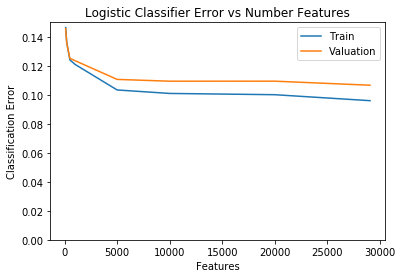

In [21]:
plt.plot(Fs,logistic_train_error,label="Train")
plt.plot(Fs,logistic_val_error,label="Valuation")
plt.legend()
plt.title("Logistic Classifier Error vs Number Features")
plt.xlabel("Features")
plt.ylabel("Classification Error")
plt.ylim(0,0.15)

In [22]:
logistic_best_idx=np.argmin(logistic_val_error)
logistic_best_idx,Fs[logistic_best_idx],logistic_val_error[logistic_best_idx]

(7, 29084, 0.10663395946130838)

1. The model is generalizing pretty well (91% train accuracy versus 89% validation accuracy) 
2. Test Error stabilizes after roughtly 5k features
3. Logistic Regression performance does not degrade after we keep increasing the number of features

Best Accuracy is $\approx 89\%$, *slightly* better than Naive Bayes

## Regularization of the Logistic Regression Classifier

In [23]:
F_best=Fs[logistic_best_idx]
F_best

29084

In [24]:
Cs=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000,1e10]

In [25]:
# Display a progress bar that counts how many training rounds we have done so far
progress3= IntProgress(min=0, max=len(Cs),description="Trials:",bar_style="info")
display(progress3)

logistic_val_error=[]
progress3.value=0
for C in Cs:
    base_model=LogisticGDClassifier(penalty=1/C,max_iter=100, learning_rate=0.005,tol=1e-8)
    model=TextChi2Classifier(F_best,base_model)
    model.fit(X,Y,X_val,Y_val)
    Y_pred=model.predict(X_val)
    acc=np.mean(Y_pred==Y_val)
    logistic_val_error.append(1-acc)
    print(C,1-acc)
    progress3.value+=1
print("Done.")

IntProgress(value=0, bar_style='info', description='Trials:', max=10)

	 0 Loss = 10693.825342427528 Train_Accuracy 0.54 Evaluation Loss = 10693.548809345273 Accuracy = 0.571
	 10 Loss = 11834.020241280581 Train_Accuracy 0.774 Evaluation Loss = 11799.948823117313 Accuracy = 0.794
	 20 Loss = 11730.837035065033 Train_Accuracy 0.775 Evaluation Loss = 11716.041514796785 Accuracy = 0.794
	 30 Loss = 11700.42567876523 Train_Accuracy 0.785 Evaluation Loss = 11690.605592555825 Accuracy = 0.792
	 40 Loss = 11200.971504512416 Train_Accuracy 0.781 Evaluation Loss = 11206.021802856036 Accuracy = 0.78
	 50 Loss = 11222.945527611282 Train_Accuracy 0.794 Evaluation Loss = 11210.079897302985 Accuracy = 0.808
	 60 Loss = 11310.783620171529 Train_Accuracy 0.762 Evaluation Loss = 11286.677870064168 Accuracy = 0.784
	 70 Loss = 11671.161547819702 Train_Accuracy 0.794 Evaluation Loss = 11685.664585639914 Accuracy = 0.787
	 80 Loss = 11045.337864106948 Train_Accuracy 0.776 Evaluation Loss = 11038.989903099944 Accuracy = 0.783
	 90 Loss = 12289.932592916759 Train_Accuracy 0.8 

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 1693.717288993652 Train_Accuracy 0.452 Evaluation Loss = 1693.6066818418017 Accuracy = 0.429
	 10 Loss = 14541.7406069151 Train_Accuracy 0.829 Evaluation Loss = 14537.09983970846 Accuracy = 0.827
	 20 Loss = 14686.410068011628 Train_Accuracy 0.823 Evaluation Loss = 14685.161185832865 Accuracy = 0.82
	 30 Loss = 14473.301340631762 Train_Accuracy 0.814 Evaluation Loss = 14460.176371823798 Accuracy = 0.832
	 40 Loss = 14562.85278485652 Train_Accuracy 0.815 Evaluation Loss = 14552.494633325146 Accuracy = 0.826
	 50 Loss = 14378.9390321896 Train_Accuracy 0.817 Evaluation Loss = 14383.544408095464 Accuracy = 0.824
	 60 Loss = 14514.804036805566 Train_Accuracy 0.808 Evaluation Loss = 14515.036553950238 Accuracy = 0.8
	 70 Loss = 14488.24337253364 Train_Accuracy 0.818 Evaluation Loss = 14489.291789447394 Accuracy = 0.819
	 80 Loss = 14712.389417578552 Train_Accuracy 0.821 Evaluation Loss = 14728.670825486552 Accuracy = 0.805
	 90 Loss = 14699.606710932809 Train_Accuracy 0.832 Evalua

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 792.7298398502647 Train_Accuracy 0.504 Evaluation Loss = 792.3874193454394 Accuracy = 0.534
	 10 Loss = 11446.313626745534 Train_Accuracy 0.874 Evaluation Loss = 11428.362554096977 Accuracy = 0.885
	 20 Loss = 11442.820821515319 Train_Accuracy 0.872 Evaluation Loss = 11467.8265511211 Accuracy = 0.862
	 30 Loss = 11422.973387003442 Train_Accuracy 0.853 Evaluation Loss = 11412.315771558377 Accuracy = 0.856
	 40 Loss = 11404.741287840374 Train_Accuracy 0.877 Evaluation Loss = 11427.712923573443 Accuracy = 0.864
	 50 Loss = 11452.49712976508 Train_Accuracy 0.875 Evaluation Loss = 11450.373122157413 Accuracy = 0.877
	 60 Loss = 11419.279725143426 Train_Accuracy 0.876 Evaluation Loss = 11448.780921152484 Accuracy = 0.862
	 70 Loss = 11473.147437956868 Train_Accuracy 0.868 Evaluation Loss = 11468.837922689601 Accuracy = 0.87
	 80 Loss = 11468.97590239128 Train_Accuracy 0.856 Evaluation Loss = 11433.08067088393 Accuracy = 0.877
	 90 Loss = 11461.163996757972 Train_Accuracy 0.867 Eva

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 703.3457220692757 Train_Accuracy 0.474 Evaluation Loss = 703.056125433617 Accuracy = 0.509
	 10 Loss = 4673.861195085731 Train_Accuracy 0.897 Evaluation Loss = 4681.642970813908 Accuracy = 0.89
	 20 Loss = 6125.3629112976805 Train_Accuracy 0.882 Evaluation Loss = 6111.92110586164 Accuracy = 0.896
	 30 Loss = 6783.835389296134 Train_Accuracy 0.885 Evaluation Loss = 6816.479617800662 Accuracy = 0.878
	 40 Loss = 7075.22688024288 Train_Accuracy 0.901 Evaluation Loss = 7096.034105523182 Accuracy = 0.894
	 50 Loss = 7279.557945228624 Train_Accuracy 0.896 Evaluation Loss = 7284.15439456807 Accuracy = 0.887
	 60 Loss = 7321.145956640137 Train_Accuracy 0.897 Evaluation Loss = 7312.400257791455 Accuracy = 0.902
	 70 Loss = 7423.427080911586 Train_Accuracy 0.869 Evaluation Loss = 7397.786453274635 Accuracy = 0.888
	 80 Loss = 7391.254669621823 Train_Accuracy 0.9 Evaluation Loss = 7421.905980310434 Accuracy = 0.875
	 90 Loss = 7399.914801213099 Train_Accuracy 0.893 Evaluation Loss = 74

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 693.8436545732084 Train_Accuracy 0.509 Evaluation Loss = 694.0970593385981 Accuracy = 0.51
	 10 Loss = 872.809925857026 Train_Accuracy 0.882 Evaluation Loss = 868.8254084330924 Accuracy = 0.881
	 20 Loss = 1212.5632925092564 Train_Accuracy 0.916 Evaluation Loss = 1268.4122218758134 Accuracy = 0.884
	 30 Loss = 1605.603279772602 Train_Accuracy 0.887 Evaluation Loss = 1598.8600230478778 Accuracy = 0.896
	 40 Loss = 1909.0052451430506 Train_Accuracy 0.888 Evaluation Loss = 1918.951707397141 Accuracy = 0.883
	 50 Loss = 2168.932787041512 Train_Accuracy 0.892 Evaluation Loss = 2208.7253365966694 Accuracy = 0.874
	 60 Loss = 2414.752187156957 Train_Accuracy 0.897 Evaluation Loss = 2412.520246724882 Accuracy = 0.902
	 70 Loss = 2643.80988695834 Train_Accuracy 0.891 Evaluation Loss = 2633.3360074391285 Accuracy = 0.904
	 80 Loss = 2844.0090724330057 Train_Accuracy 0.89 Evaluation Loss = 2857.506672502844 Accuracy = 0.891
	 90 Loss = 3024.289035963312 Train_Accuracy 0.898 Evaluation 

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 693.0798087043185 Train_Accuracy 0.533 Evaluation Loss = 693.3065684773686 Accuracy = 0.509
	 10 Loss = 340.64534459611866 Train_Accuracy 0.89 Evaluation Loss = 336.9257406030827 Accuracy = 0.885
	 20 Loss = 362.64740675624705 Train_Accuracy 0.91 Evaluation Loss = 358.78353471659256 Accuracy = 0.888
	 30 Loss = 409.00512064280554 Train_Accuracy 0.888 Evaluation Loss = 399.3057589014081 Accuracy = 0.901
	 40 Loss = 423.3742881269493 Train_Accuracy 0.903 Evaluation Loss = 430.63683268125703 Accuracy = 0.904
	 50 Loss = 459.2323472156579 Train_Accuracy 0.897 Evaluation Loss = 501.8587032083018 Accuracy = 0.886
	 60 Loss = 504.0593658817821 Train_Accuracy 0.895 Evaluation Loss = 551.3097199478507 Accuracy = 0.879
	 70 Loss = 539.2395182662547 Train_Accuracy 0.905 Evaluation Loss = 564.5358870183768 Accuracy = 0.903
	 80 Loss = 593.8743270113995 Train_Accuracy 0.896 Evaluation Loss = 624.3495135899018 Accuracy = 0.881
	 90 Loss = 615.997362918243 Train_Accuracy 0.9 Evaluation Los

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 694.0022506968222 Train_Accuracy 0.443 Evaluation Loss = 694.3376138129959 Accuracy = 0.436
	 10 Loss = 285.45844781296665 Train_Accuracy 0.888 Evaluation Loss = 276.50781551506003 Accuracy = 0.896
	 20 Loss = 284.69086181571345 Train_Accuracy 0.887 Evaluation Loss = 279.0063888278644 Accuracy = 0.891
	 30 Loss = 247.80024718636656 Train_Accuracy 0.901 Evaluation Loss = 283.44703213438316 Accuracy = 0.896
	 40 Loss = 257.85919157033953 Train_Accuracy 0.912 Evaluation Loss = 296.42650032814964 Accuracy = 0.882
	 50 Loss = 278.32075215400505 Train_Accuracy 0.898 Evaluation Loss = 319.20483177791573 Accuracy = 0.881
	 60 Loss = 270.8731033249655 Train_Accuracy 0.899 Evaluation Loss = 293.47020583843397 Accuracy = 0.891
	 70 Loss = 282.9197747372006 Train_Accuracy 0.892 Evaluation Loss = 269.8954230517264 Accuracy = 0.897
	 80 Loss = 299.71168160356507 Train_Accuracy 0.89 Evaluation Loss = 328.3401297071672 Accuracy = 0.893
	 90 Loss = 291.3303083112959 Train_Accuracy 0.898 Eval

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 692.5353337422562 Train_Accuracy 0.547 Evaluation Loss = 692.5028674960389 Accuracy = 0.523
	 10 Loss = 286.61573223308994 Train_Accuracy 0.868 Evaluation Loss = 286.32813367967077 Accuracy = 0.892
	 20 Loss = 307.65397044082124 Train_Accuracy 0.875 Evaluation Loss = 299.8559529587343 Accuracy = 0.882
	 30 Loss = 243.7530095565764 Train_Accuracy 0.911 Evaluation Loss = 249.3947246312322 Accuracy = 0.908
	 40 Loss = 274.6451351537993 Train_Accuracy 0.886 Evaluation Loss = 263.17424215887957 Accuracy = 0.894
	 50 Loss = 253.70889573302702 Train_Accuracy 0.9 Evaluation Loss = 260.79037921210744 Accuracy = 0.897
	 60 Loss = 266.3760374605632 Train_Accuracy 0.888 Evaluation Loss = 273.8479024316828 Accuracy = 0.89
	 70 Loss = 270.247558904072 Train_Accuracy 0.9 Evaluation Loss = 313.2309357832646 Accuracy = 0.879
	 80 Loss = 254.11323364476806 Train_Accuracy 0.904 Evaluation Loss = 306.7723421059175 Accuracy = 0.882
	 90 Loss = 239.25610943783641 Train_Accuracy 0.913 Evaluation L

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 693.5096949477544 Train_Accuracy 0.466 Evaluation Loss = 693.6269191285008 Accuracy = 0.464
	 10 Loss = 305.89380305420326 Train_Accuracy 0.871 Evaluation Loss = 277.4338350125649 Accuracy = 0.883
	 20 Loss = 253.55505253649272 Train_Accuracy 0.897 Evaluation Loss = 263.3587930135532 Accuracy = 0.899
	 30 Loss = 246.48070943197777 Train_Accuracy 0.897 Evaluation Loss = 258.4340400327692 Accuracy = 0.889
	 40 Loss = 270.53217426302894 Train_Accuracy 0.885 Evaluation Loss = 259.22544253700323 Accuracy = 0.894
	 50 Loss = 268.80251126351953 Train_Accuracy 0.893 Evaluation Loss = 304.62323885608635 Accuracy = 0.891
	 60 Loss = 255.652881858463 Train_Accuracy 0.903 Evaluation Loss = 299.1090254339194 Accuracy = 0.881
	 70 Loss = 252.99333951780866 Train_Accuracy 0.905 Evaluation Loss = 282.29343097453136 Accuracy = 0.886
	 80 Loss = 244.94529590375842 Train_Accuracy 0.895 Evaluation Loss = 248.08931170126746 Accuracy = 0.902
	 90 Loss = 261.7985981328324 Train_Accuracy 0.91 Evalu

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


	 0 Loss = 692.525431492221 Train_Accuracy 0.525 Evaluation Loss = 692.6389761482366 Accuracy = 0.494
	 10 Loss = 248.76245071012258 Train_Accuracy 0.895 Evaluation Loss = 282.916626770213 Accuracy = 0.876
	 20 Loss = 264.9823829370913 Train_Accuracy 0.886 Evaluation Loss = 279.63544127652995 Accuracy = 0.885
	 30 Loss = 254.34581918366732 Train_Accuracy 0.903 Evaluation Loss = 312.89810618705036 Accuracy = 0.869
	 40 Loss = 245.05269639619192 Train_Accuracy 0.9 Evaluation Loss = 279.2634147000444 Accuracy = 0.878
	 50 Loss = 280.5513780489585 Train_Accuracy 0.874 Evaluation Loss = 289.08244140159604 Accuracy = 0.89
	 60 Loss = 269.0239823547 Train_Accuracy 0.901 Evaluation Loss = 300.9097452176205 Accuracy = 0.878
	 70 Loss = 252.71999671812864 Train_Accuracy 0.889 Evaluation Loss = 289.2228743185717 Accuracy = 0.88
	 80 Loss = 247.73636809403098 Train_Accuracy 0.91 Evaluation Loss = 275.81035482673667 Accuracy = 0.89
	 90 Loss = 276.7523834511055 Train_Accuracy 0.896 Evaluation Loss 

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


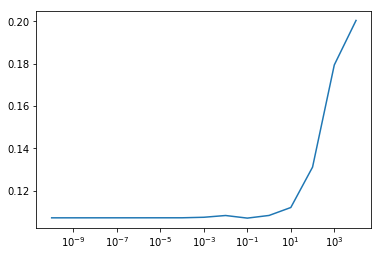

In [26]:
plt.semilogx(1/np.array(Cs),logistic_val_error)

In [27]:
logistic_val_error=np.array(logistic_val_error)
print("C,error")
for idx,C in enumerate(Cs):
    print(C,logistic_val_error[idx])

C,error
0.0001 0.20045542503078517
0.001 0.17943355290162433
0.01 0.13117413654932464
0.1 0.11210687828619459
1 0.10835401966341551
10 0.10709329371982568
100 0.10832470045542508
1000 0.107493989562362
10000 0.10724966282910808
10000000000.0 0.1072301166904478


In [28]:
best_idx=logistic_val_error.argmin()
best_C=Cs[best_idx]
print(best_idx,best_C,logistic_val_error[best_idx])

5 10 0.10709329371982568


## Test best model

Best model is logistic regression, with C=10 used on all features

In [29]:
X=countVectorizer.fit_transform(documents["Summary"])
X_test=countVectorizer.transform(test_documents["Summary"])


In [30]:
Y=documents["Score"]>3
Y_test=test_documents["Score"]>3

In [31]:
base_model=LogisticGDClassifier(penalty=1/best_C,max_iter=100, learning_rate=0.005,tol=1e-8)
model=TextChi2Classifier(F_best,base_model)

In [32]:
model.fit(X,Y,X_test,Y_test)

	 0 Loss = 692.5875060979083 Train_Accuracy 0.539 Evaluation Loss = 692.660018572228 Accuracy = 0.548
	 10 Loss = 345.01313047336026 Train_Accuracy 0.899 Evaluation Loss = 349.1367412319402 Accuracy = 0.887
	 20 Loss = 393.7608255567423 Train_Accuracy 0.88 Evaluation Loss = 414.29650144168744 Accuracy = 0.879
	 30 Loss = 446.9316089255923 Train_Accuracy 0.895 Evaluation Loss = 436.7301767369763 Accuracy = 0.882
	 40 Loss = 494.38427362353104 Train_Accuracy 0.887 Evaluation Loss = 469.8574195087911 Accuracy = 0.896
	 50 Loss = 499.64961590822725 Train_Accuracy 0.893 Evaluation Loss = 517.1144909985813 Accuracy = 0.89
	 60 Loss = 563.1245821155295 Train_Accuracy 0.889 Evaluation Loss = 556.7141212522481 Accuracy = 0.895
	 70 Loss = 582.3752955304623 Train_Accuracy 0.898 Evaluation Loss = 586.3758644067892 Accuracy = 0.906
	 80 Loss = 612.0367717411063 Train_Accuracy 0.9 Evaluation Loss = 573.7166141482347 Accuracy = 0.919
	 90 Loss = 658.513088501644 Train_Accuracy 0.894 Evaluation Loss 

In [33]:
Y_pred=model.predict(X_test)
np.mean(Y_pred==Y_test)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8933961932237976

## ROC Curve

In [34]:

prob=model.predict_proba(X_test)
fpr,tpr,threshold=metrics.roc_curve(Y_test,prob[:,1])
roc=np.c_[fpr,tpr,threshold]
data=pd.DataFrame(roc,columns=["fpr","tpr","threshold"])
data.to_csv(data_dir+"/logistic_roc.csv",index=False)


In [35]:
auc=metrics.roc_auc_score(Y_test,prob[:,1])
print(auc)

0.9305065430541628


In [36]:
ht=np.argmin((threshold-0.5)**2)
print(ht,threshold[ht])
print(fpr[ht],tpr[ht])
print("Accuracy",(1-fpr[ht])*np.mean(Y_test==0)+tpr[ht]*np.mean(Y_test==1))

11391 0.499971989359619
0.33847769877181644 0.9579491792219473
Accuracy 0.8934137846110544


In [37]:
set_roc=pd.read_csv(data_dir+"/set_roc.csv")
set_roc.head()
set_ht=((set_roc["threshold"]-0.5)**2).argmin()
print(set_ht,set_roc["threshold"].iloc[ht])
set_fpr=set_roc["fpr"].iloc[ht]
set_tpr=set_roc["tpr"].iloc[ht]
print(set_fpr,set_tpr)
print("Accuracy",(1-set_fpr)*np.mean(Y_test==0)+set_tpr*np.mean(Y_test==1))

11192 0.4695317460646202
0.3358920491273432 0.9394423206656172
Accuracy 0.8794989972909263


/home/manel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'True Positive Rate')

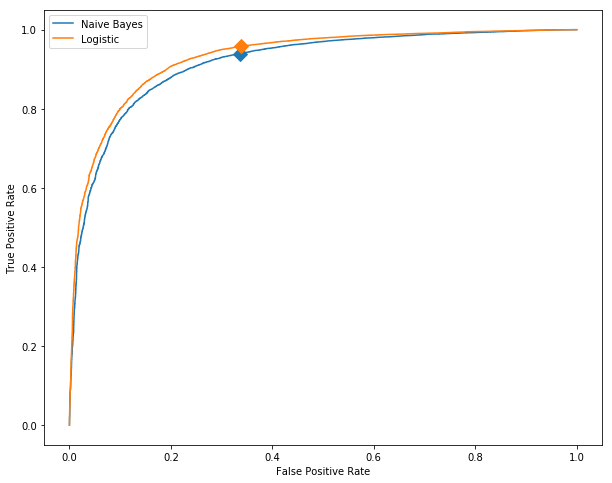

In [38]:
plt.figure(figsize=(10,8))
plt.clf()
plt.subplot(111)
ax = plt.gca()

color = next(ax._get_lines.prop_cycler)['color']
plt.plot(set_roc["fpr"],set_roc["tpr"],label="Naive Bayes",color=color)
plt.plot([set_fpr], [set_tpr], marker='D', markersize=10, color=color)


color = next(ax._get_lines.prop_cycler)['color']
plt.plot(fpr,tpr,label="Logistic",color=color)
plt.plot([fpr[ht]], [tpr[ht]], marker='D', markersize=10, color=color)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")